Analyze the output of metagenome-atlas
======================================

In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen' # ete3 has some interactive part, but we don't have acces to them here

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load libraries

%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

#load my scripts
from utils.mag_scripts import * 
from utils.barplots import * 

import ete3



In [4]:
# Define filepaths

atlas_wd_folder = "../Example/"

taxonomy_file = os.path.join(atlas_wd_folder,"genomes/taxonomy/gtdb_taxonomy.tsv")
tree_file = os.path.join(atlas_wd_folder,"genomes/tree/gtdbtk.bac120.nwk")
quality_file= os.path.join(atlas_wd_folder,"genomes/checkm/completeness.tsv")
counts_file= os.path.join(atlas_wd_folder,"genomes/counts/raw_counts_genomes.tsv")
abundance_file = os.path.join(atlas_wd_folder,"genomes/counts/median_coverage_genomes.tsv")
readstats_file= os.path.join(atlas_wd_folder,"stats/read_counts.tsv")
keggmodules_file = os.path.join(atlas_wd_folder,"genomes/annotations/dram/kegg_modules.tsv")


# Taxonomy

In [5]:
Tax= pd.read_table(taxonomy_file,index_col=0)
Tax.head()

,Domain,phylum,class,order,family,genus,species
user_genome,,,,,,,
MAG01,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola vulgatus
MAG02,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Anaerosacchariphilus,NaN
MAG03,Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Atopobiaceae,NM07-P-09,NM07-P-09 sp004793925
MAG04,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Paramuribaculum,Paramuribaculum sp900752995
MAG05,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Acetatifactor,Acetatifactor sp011959105


In [6]:
# create a short label for each species
Labels=Tax.ffill(axis=1).species.copy()
Labels.loc[Tax.species.isnull()]+= ' '+ Labels.index[Tax.species.isnull()]

## Draw tree

In [7]:
T= ete3.Tree(tree_file)

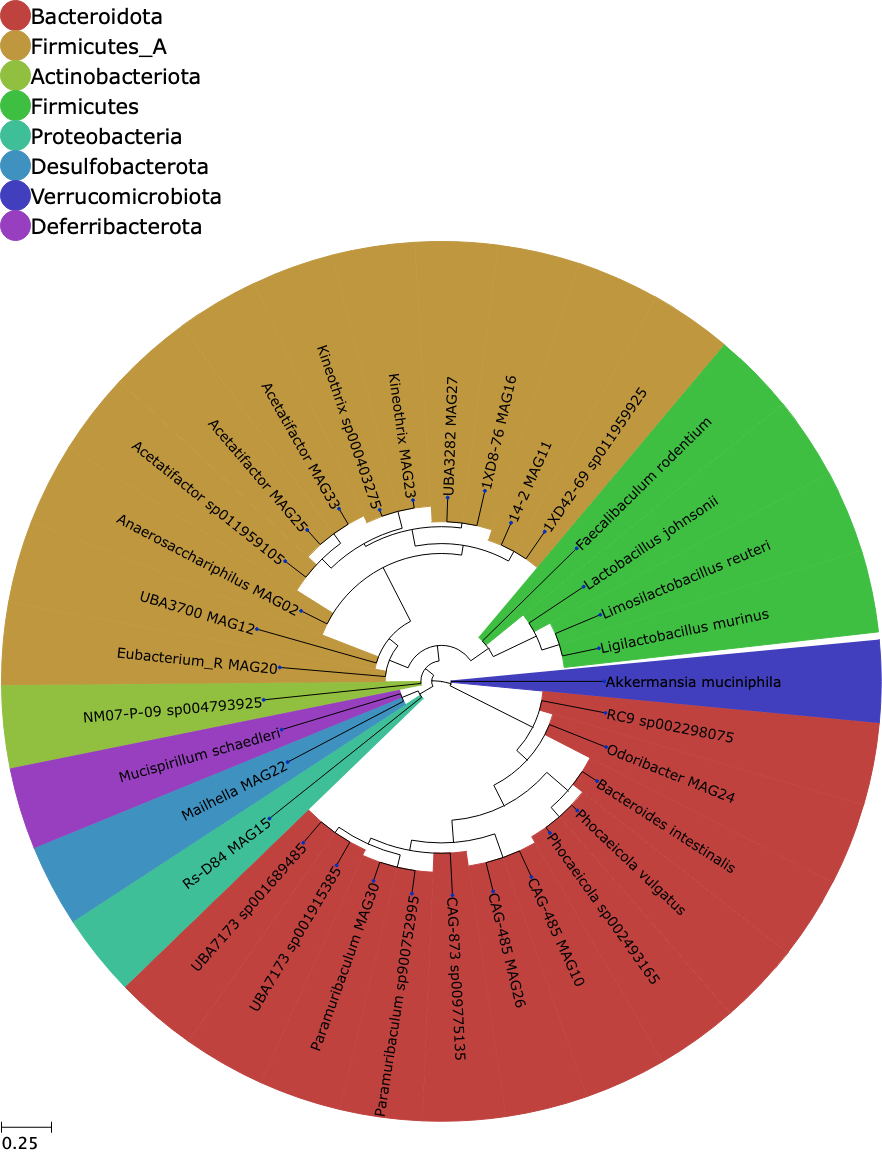

In [8]:
unique_phyla= Tax.phylum.unique()
phyla_colors= dict(zip(unique_phyla, 
['#bf423f',
 '#bf973f',
 '#91bf3f',
 '#3fbf42',
 '#3fbf97',
 '#3f91bf',
 '#423fbf',
 '#973fbf',
 '#bf3f91']))
    

def layout(node):
    node.img_style["size"] = 0
    if node.is_leaf():
        L= ete3.TextFace(Labels.loc[node.name])
        ete3.add_face_to_node(L, node, 0, position="branch-right")        
        node.set_style(ete3.NodeStyle(bgcolor= phyla_colors[Tax.loc[node.name,'phylum']]))
        


ts=ete3.TreeStyle()
ts.mode='c'
ts.show_leaf_name=False
ts.scale = 200

for ph in unique_phyla:
    ts.title.add_face(ete3.CircleFace(radius=15,color= phyla_colors[ph] ), column=0)
    ts.title.add_face(ete3.TextFace(ph, fsize=15), column=1)

T.render('%%inline',tree_style=ts,layout=layout)

# Genome quality 

In [9]:
genome_quality= pd.read_table(quality_file,index_col=0)

genome_quality['Quality_Score']= genome_quality.eval('Completeness -5*Contamination')
genome_quality['Lineage']= genome_quality['Marker lineage'].map(lambda s: s.split()[0])

genome_quality['Id']= genome_quality.index

genome_quality= genome_quality.join(Tax)
genome_quality['Name']= Labels

In [10]:

xscale = alt.Scale(domain=(0, 10))
yscale = alt.Scale(domain=(50, 100))

alt.Chart(genome_quality).mark_circle(opacity= .6).encode(
    alt.X('Contamination', scale=xscale, title='Contamination [%]'),
    alt.Y('Completeness', scale=yscale, title='Completeness [%]'),
    color='phylum',
    tooltip=['Name', 'Id', 'Contamination','Completeness' ]
).interactive()

alt.Chart(...)

# Abundance

## Mapping rate

In [14]:
# calculate mapping  rate
Counts= pd.read_csv(counts_file,index_col=0,sep='\t').T
read_stats= pd.read_csv(readstats_file,index_col=0,sep='\t').query('Step=="QC"')


mapped_reads = Counts.sum(1)
total_reads = read_stats.eval('Reads_pe *2 + Reads_se')

mapping_rate = mapped_reads/total_reads *100




Text(0.5, 1.0, 'Mapping rate')

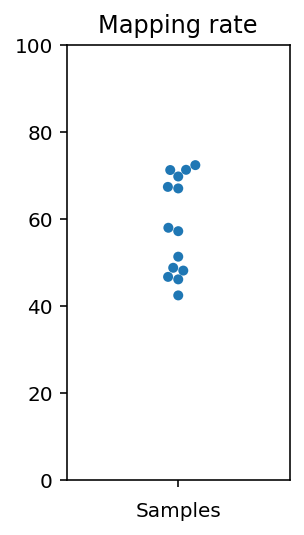

In [15]:
f,ax= plt.subplots(figsize=(2,4))
ax.set_ylim([0,100])
ax.set_xlabel('Samples')
sns.swarmplot(y= mapping_rate,ax=ax)

ax.set_title('Mapping rate')


## Relative abundance


For the relative abundance, we take the coverage over the genome, not the raw counts. This implicitly normalizes for genome size. The coverage is calculated as the median of the coverage values calculated in 1kb blocks.

In [19]:
D = pd.read_table(abundance_file,index_col=0)


#calculate relative abundance

relab = (D.T/D.sum(1)).T

relab.head()

,MAG01,MAG02,MAG03,MAG04,MAG05,MAG06,MAG07,MAG08,MAG09,MAG10,...,MAG24,MAG25,MAG26,MAG27,MAG28,MAG29,MAG30,MAG31,MAG32,MAG33
ERR675519,0.006659,0.027047,0.046828,0.000000,0.063111,0.041362,0.060065,0.056439,0.000593,0.000000,...,0.014706,0.015151,0.000000,0.017240,0.000324,0.187581,0.013318,0.004233,0.005163,0.001132
ERR675520,0.036956,0.000325,0.000000,0.068008,0.000000,0.000000,0.000241,0.000000,0.095427,0.088046,...,0.009917,0.000771,0.035884,0.000205,0.009664,0.122857,0.028600,0.005127,0.040752,0.001072
ERR675521,0.027845,0.043441,0.000000,0.016804,0.077984,0.068979,0.000000,0.051074,0.001694,0.002181,...,0.015811,0.019822,0.000000,0.024456,0.000623,0.138892,0.021477,0.008918,0.008509,0.030317
ERR675522,0.040169,0.000387,0.046611,0.000115,0.000401,0.000000,0.000000,0.000000,0.063746,0.216792,...,0.006242,0.001217,0.000000,0.001675,0.000000,0.136025,0.000115,0.008682,0.045709,0.003736
ERR675523,0.037786,0.006432,0.002740,0.036424,0.005382,0.000148,0.000000,0.076409,0.008696,0.002658,...,0.011272,0.016654,0.000000,0.007351,0.000459,0.262125,0.028779,0.006768,0.009762,0.032109


Text(0, 0.5, 'Abundance [%]')

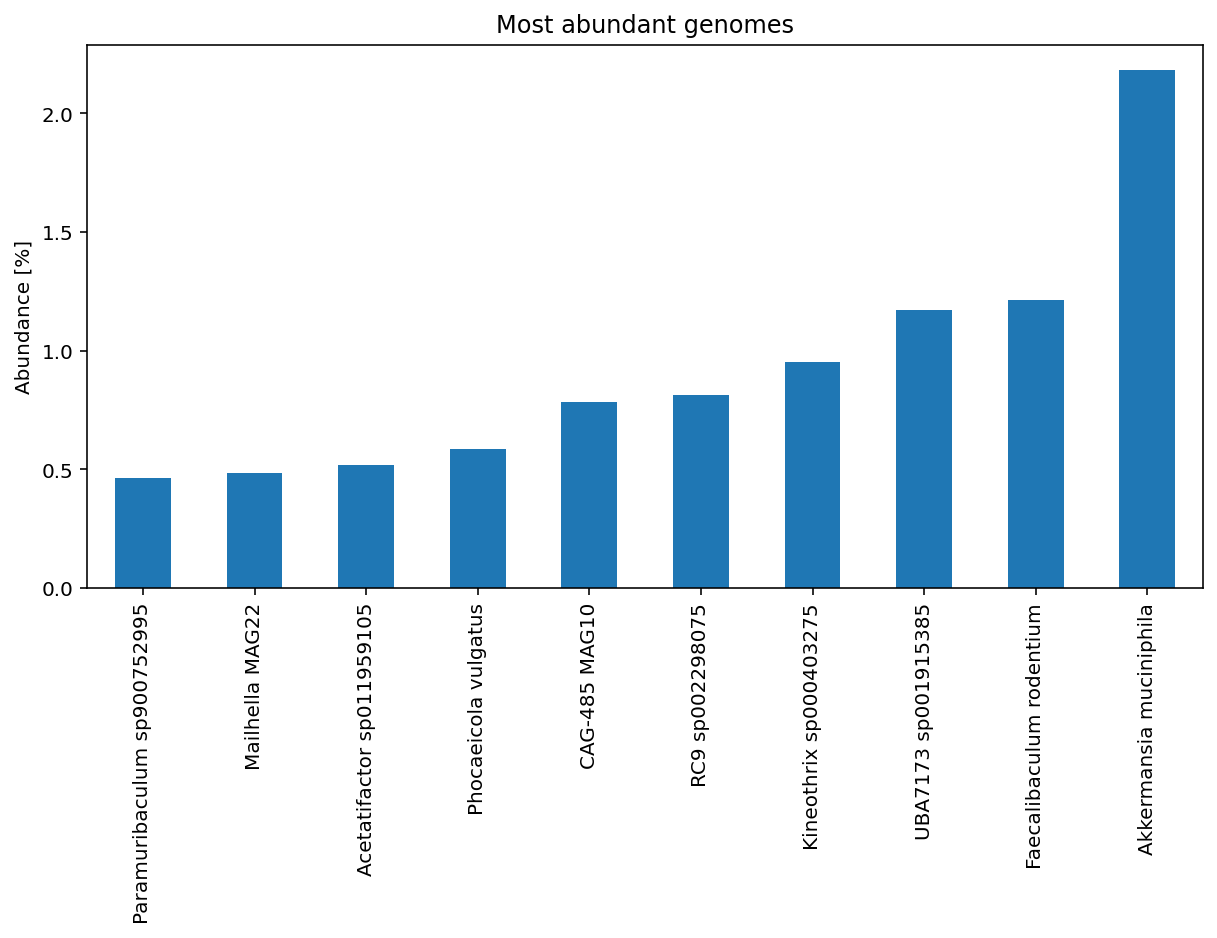

In [20]:
# get most abundant genomes

counts_per_genome= relab.sum().sort_values()
ax= counts_per_genome[-10:].plot.bar(figsize=(10,5))

_= ax.set_xticklabels(Labels.loc[counts_per_genome.index[-10:]])
ax.set_title('Most abundant genomes')
ax.set_ylabel('Abundance [%]')

### Typical bar chart

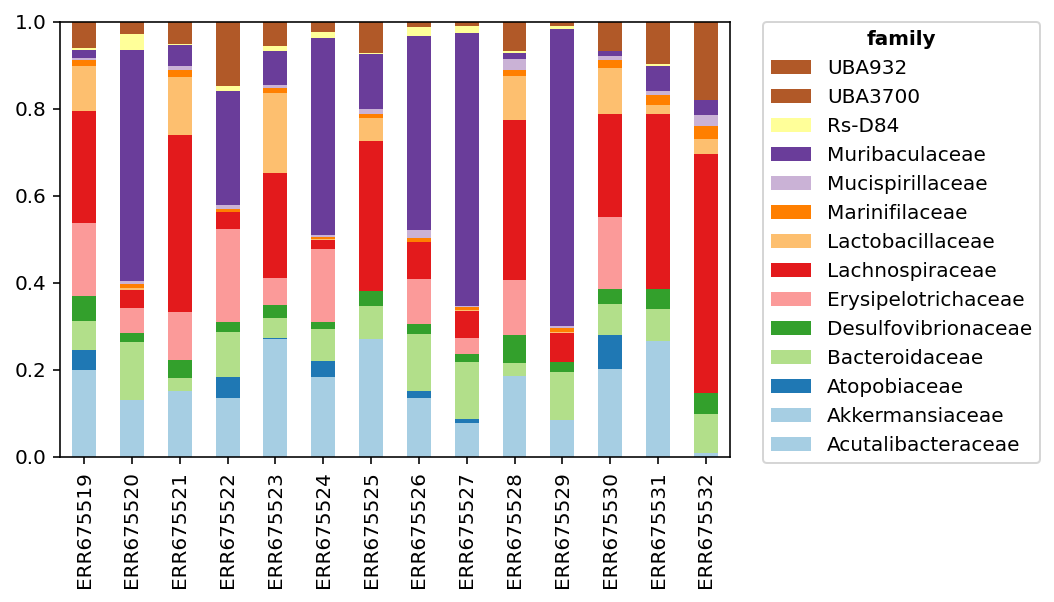

In [21]:

level='family'

grouped_data =relab.groupby(Tax[level],axis=1).sum()

ax= BarPlot(grouped_data)

ax.legend_.set_title(level,{'weight':'bold'})


# Functional annotation


The relative abundance of functional annotations per sample.

The abundance is calculated as the sum of the relative abundance of all bacteria containing a function.


## Kegg modules produced by Dram

In [42]:
kegg_modules= pd.read_table(keggmodules_file,index_col=[1,2]).drop('Unnamed: 0',axis=1)
module_names =kegg_modules.module_name.droplevel(0).drop_duplicates()
kegg_modules.head()

module_name  steps  \
genome module                                                             
MAG14  M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...      9   
       M00002  Glycolysis, core module involving three-carbon...      5   
       M00003       Gluconeogenesis, oxaloacetate => fructose-6P      7   
       M00004  Pentose phosphate pathway (Pentose phosphate c...      7   
       M00005               PRPP biosynthesis, ribose 5P => PRPP      1   

               steps_present  step_coverage  ko_count  \
genome module                                           
MAG14  M00001              9       1.000000        10   
       M00002              5       1.000000         6   
       M00003              7       1.000000         7   
       M00004              4       0.571429         4   
       M00005              1       1.000000         1   

                                                     kos_present  \
genome module                                                      
MAG14  M00001  K00134,K00845,K00850,K00873,K00927,K01624,K016...   
       M00002          K00134,K00873,K00927,K01689,K01803,K15633   
       M00003   K00134,K00927,K01610,K01624,K01689,K01803,K15633   
       M00004                        K00615,K01783,K01808,K01810   
       M00005                                             K00948   

                                                   genes_present  
genome module                                                     
MAG14  M00001  MAG14_MAG14_10_17,MAG14_MAG14_12_4,MAG14_MAG14...  
       M00002  MAG14_MAG14_12_4,MAG14_MAG14_14_31,MAG14_MAG14...  
       M00003  MAG14_MAG14_14_31,MAG14_MAG14_28_28,MAG14_MAG1...  
       M00004  MAG14_MAG14_10_17,MAG14_MAG14_34_18,MAG14_MAG1...  
       M00005                                  MAG14_MAG14_15_23

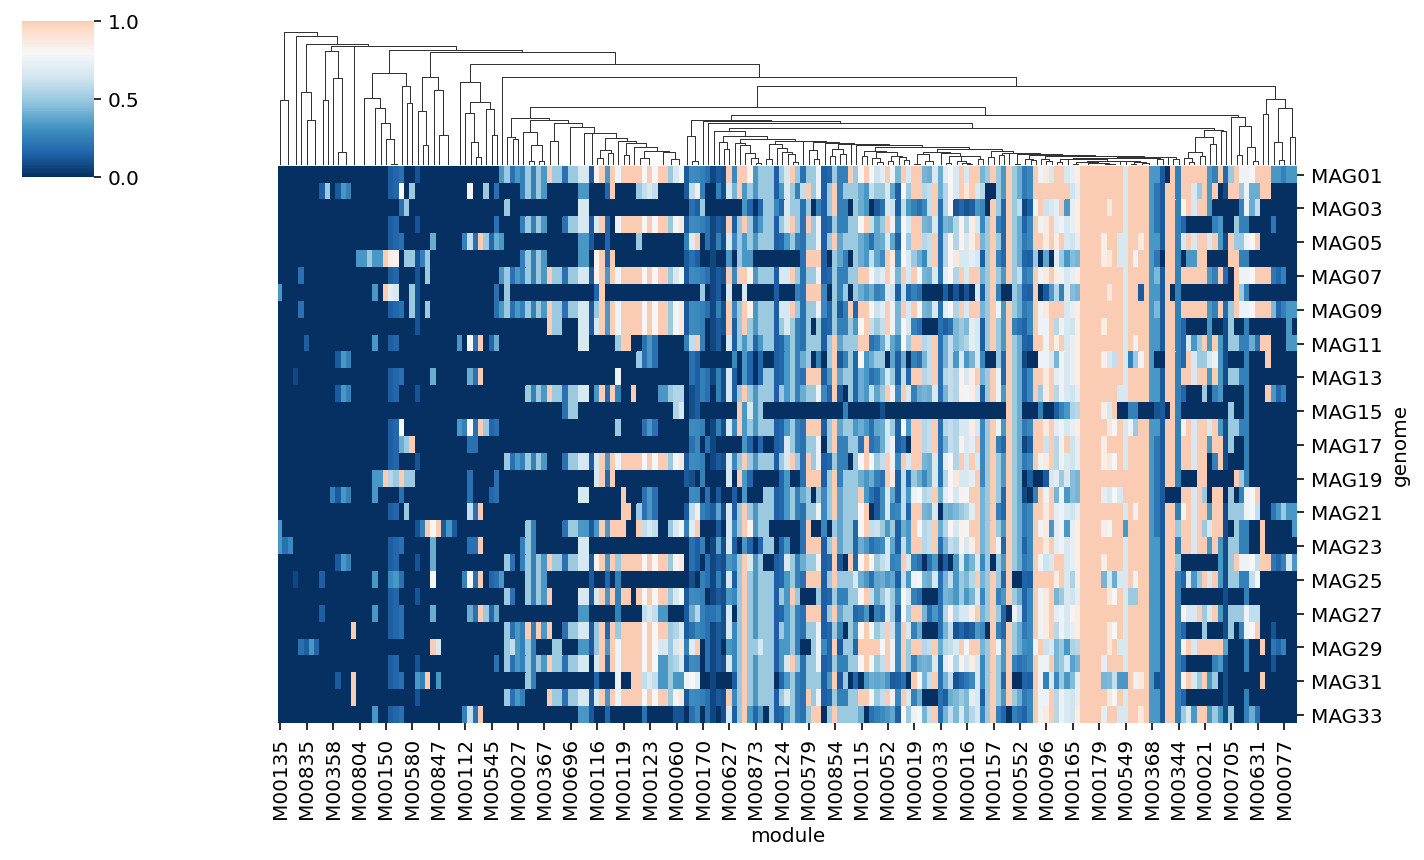

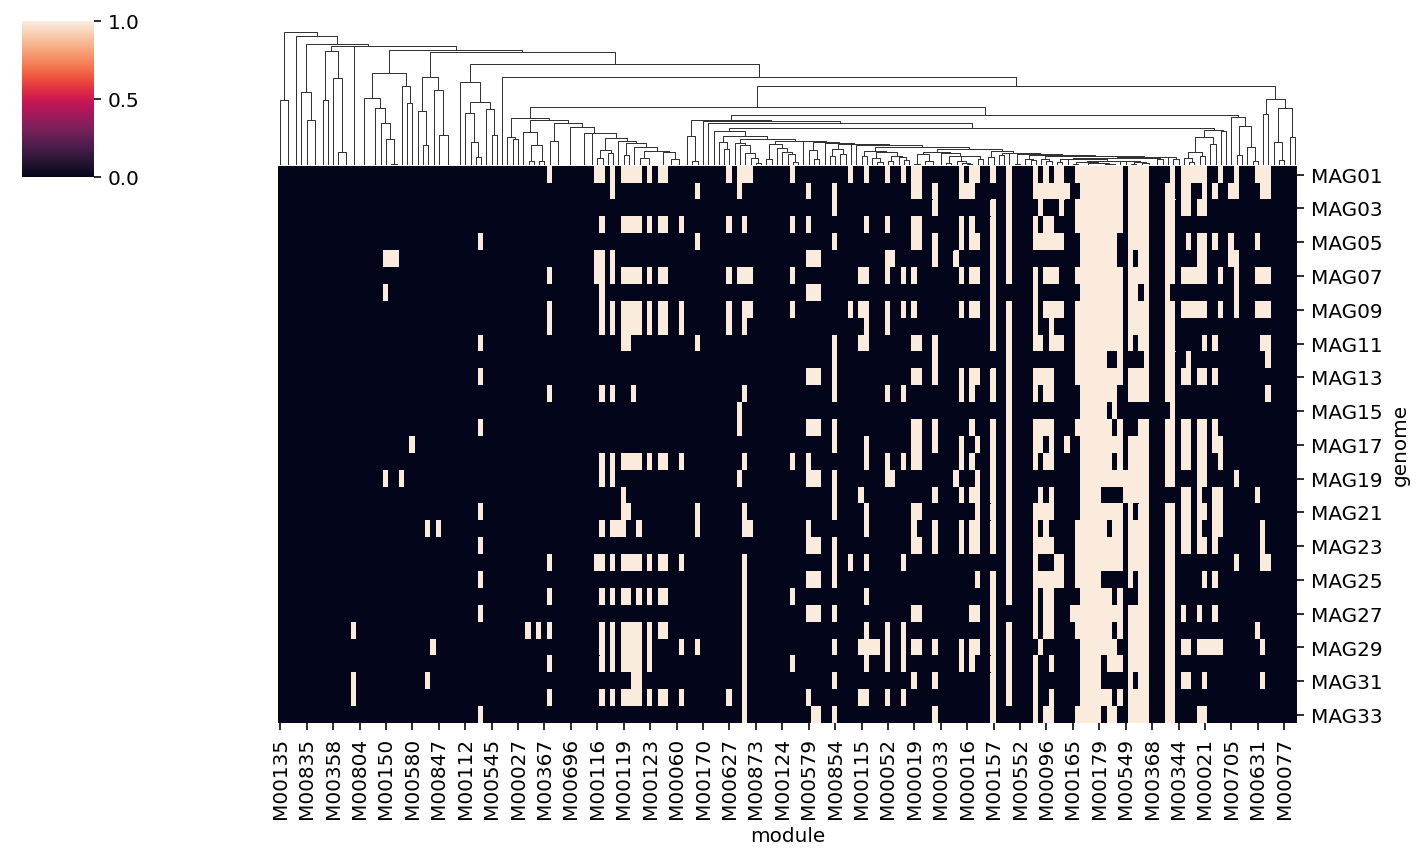

In [63]:
# Calculate module step coverage per genome

step_coverage_threshold= 0.8
module_step_coverage_matrix = kegg_modules.step_coverage.unstack(fill_value=0)
module_step_coverage_matrix= module_step_coverage_matrix.loc[:, module_step_coverage_matrix.max()>0]



cgi= sns.clustermap(module_step_coverage_matrix,
metric='cosine',
figsize=(10,6),row_cluster=False,
center= step_coverage_threshold,cmap= 'RdBu_r',vmax=1,vmin=0)

cgi_bin=sns.clustermap(module_step_coverage_matrix> step_coverage_threshold,
                   figsize=(10,6),
                   row_cluster=False,
                       col_linkage= cgi.dendrogram_col.linkage
                  )



module_presence_matrix = (module_step_coverage_matrix > step_coverage_threshold) *1
#drop all 0 modules
module_presence_matrix= module_presence_matrix.loc[:,module_presence_matrix.max()>0]




In [ ]:
#Todo interactive heatmap

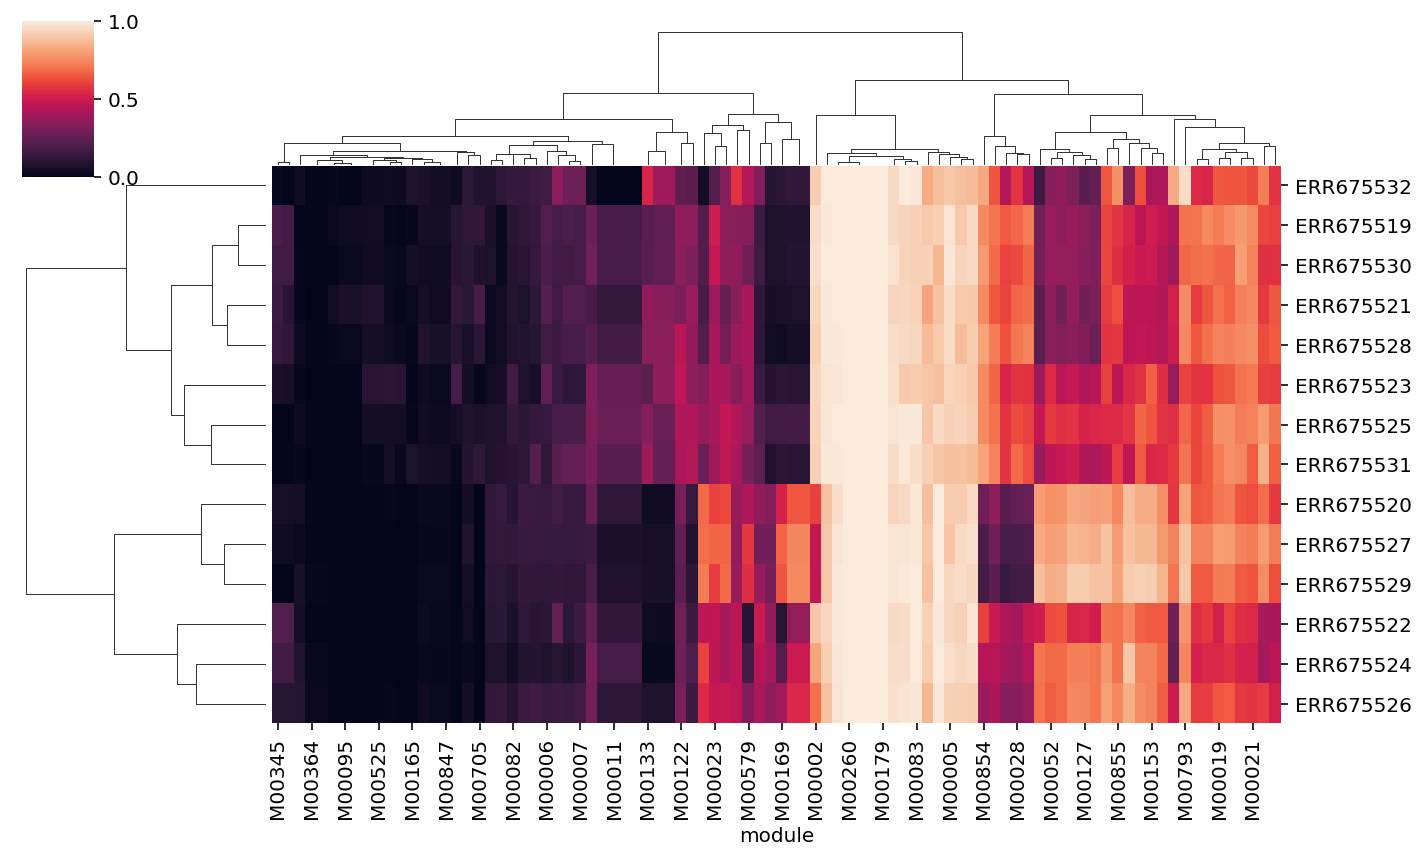

In [55]:
# Module abundance
# Sum of rel_ab for all species where a module is presence is equel to the matrix multiplication

assert relab.shape[1] == module_presence_matrix.shape[0], "Relab and module matrix shoul dhave the same shape"


module_relab = relab @ module_presence_matrix

sns.clustermap(module_relab, figsize=(10,6),
                   )

